In [ ]:
# inspired from: A deep understanding of deep learning
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # further normalization
                        T.Resize((98,98))
                       ])

trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
X,y = next(iter(testset))

print('Data shapes (train/test):')
print( X.data.shape )

print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data),torch.mean(X.data)) )
print(X.data.shape[1])

Data shapes (train/test):
torch.Size([3, 98, 98])

Data value range:
(tensor(-1.8840), tensor(2.3868), tensor(0.3205))
98


torch.Size([3, 98, 98])
6
torch.Size([3, 98, 98])
6


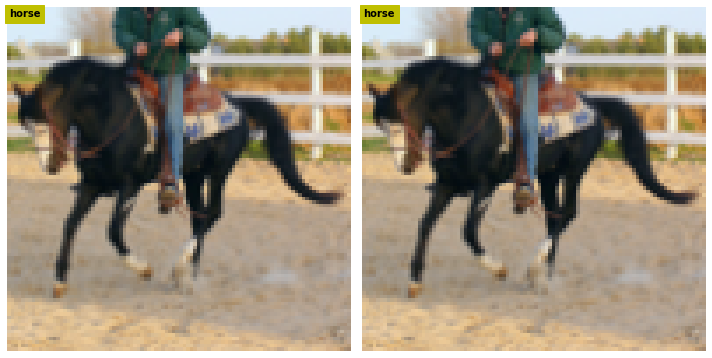

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):
  print(X.data.shape)
  pic = X.data.cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  print(y)
  label = testset.classes[y]

  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
a = np.random.rand(256,98,98)
for i in a:
  print(i.shape)

In [ ]:
import cv2

class Permutar():
  def __init__(self,block_size):
    self.block_size = block_size
    #self.image = self.reshape(np.array(image))
    self.image_size = 98 #self.image.shape[0]
    self.key = np.argsort(np.random.rand((self.image_size//self.block_size)**2))

  def get_pixels_positions(self,block_num):
    base = np.sort([i + j*self.image_size for i in range(self.block_size) for j in range(self.block_size)]) 
    row_blocks = self.image_size // self.block_size
    block = base + self.block_size * (block_num % row_blocks)  + ((block_num // row_blocks)) * 98 * self.block_size
    return block

  def desordenar(self,image):
    canales = np.array([image[:,:,i].flatten() for i in range(3)])
    ar = np.copy(canales)
    for a,b in enumerate(self.key):
      place = self.get_pixels_positions(a)
      replace = self.get_pixels_positions(b)
      for i,channel in enumerate(canales):
        channel[ place ] = ar[i][replace]

    return canales.T.reshape(98,98,3)

  def reordenar(self,image_permuted,first_layer=False):
      canales = []
      if first_layer:
        for i in range(image_permuted.shape[0]):
          for k in range(64):
            canales.append(image_permuted[i,:,:,k].flatten())
        canales = np.array(canales)
      else:
        canales = np.array([image_permuted[:,:,i].flatten() for i in range(3)])
      ar = np.copy(canales)
      for a,b in enumerate(self.key):
        print(a)
        place = self.get_pixels_positions(b)
        replace = self.get_pixels_positions(a)
        for i,channel in enumerate(canales):
            channel[ place ] = ar[i][replace]

      if first_layer:
        return canales.T.reshape(image_permuted.shape[0],98,98,64)
      else:
        return canales.T.reshape(98,98,3)



  def reshape(self,image):
    row_blocks = round(image.shape[0]/self.block_size)
    image = cv2.resize(image, (row_blocks*self.block_size,row_blocks*self.block_size))
    return image

  def __call__(self,img):
    img = img.numpy().transpose((1,2,0))
    img = self.desordenar(img).transpose((2,0,1))
    return  torch.from_numpy(img)

(98, 98, 3)


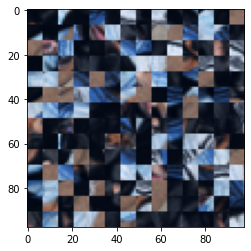

In [ ]:
img = Permutar(7)
permuted_image = img.desordenar(pic)
print(permuted_image.shape)
plt.imshow(permuted_image)

In [ ]:
original_image = img.reordenar(permuted_image)
print(original_image.shape)
plt.imshow(original_image)

(9604,)
()


TypeError: ignored

In [ ]:
vggnet = torchvision.models.vgg16(pretrained=True)
summary(vggnet.to(device),(3,98,98))

vggnet.features = nn.Sequential(*list(vggnet.features.children())[1:])
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features,10)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 98, 98]           1,792
              ReLU-2           [-1, 64, 98, 98]               0
            Conv2d-3           [-1, 64, 98, 98]          36,928
              ReLU-4           [-1, 64, 98, 98]               0
         MaxPool2d-5           [-1, 64, 49, 49]               0
            Conv2d-6          [-1, 128, 49, 49]          73,856
              ReLU-7          [-1, 128, 49, 49]               0
            Conv2d-8          [-1, 128, 49, 49]         147,584
              ReLU-9          [-1, 128, 49, 49]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [ ]:
vggnet

VGG(
  (features): Sequential(
    (0): ReLU(inplace=True)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(256, 512, kernel_size=(3, 3), stride=(1

# comparation of feature maps

In [ ]:
first_layer = vggnet.features[0]
# Extrae el kernel (pesos) de la primera capa
kernel = first_layer.weight.data

In [ ]:
from scipy import ndimage
result = ndimage.convolve(original_image.transpose((2,0,1)), kernel[5].cpu())
print(result.shape)
result = result.transpose((1,2,0))
result = result-np.min(result) # undo normalization
result = result/np.max(result)
plt.imshow(result)

(3, 96, 96)


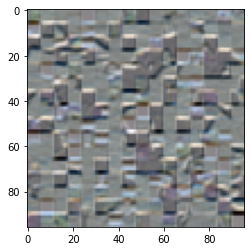

In [ ]:
from scipy import ndimage
result = ndimage.convolve(permuted_image.transpose((2,0,1)), kernel[5].cpu())
print(result.shape)
result = result.transpose((1,2,0))
result = result-np.min(result) # undo normalization
result = result/np.max(result)
plt.imshow(result)

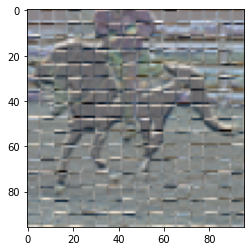

In [ ]:
reordered_conv = img.reordenar(result)
plt.imshow(reordered_conv)

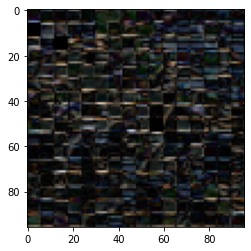

In [ ]:
"""mean absolute error"""
plt.imshow(np.absolute(result - reordered_conv))

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

print(f"psnr = {peak_signal_noise_ratio(result, reordered_conv)}")
print(f"mse = {mean_squared_error(result, reordered_conv)}")

psnr = 15.551075587249697
mse = 0.027854312346166726


# Custom VGG

In [ ]:
import torch
import torch.nn as nn


class CustomVGG(nn.Module):
  def __init__(self, vgg):
    super(CustomVGG,self).__init__()
    self.conv1 = nn.Conv2d(3, 64, stride=7, kernel_size=(7, 7),padding=0)
    self.vgg = vgg
    self.kernel_aux = torch.ones(7,7).cuda()
    
  def forward(self, x):
    #first layer
    x = self.conv1(x)
    x = torch.kron(x,self.kernel_aux)

    x = self.vgg(x)


    return x

net = CustomVGG(vggnet).to(device)

In [ ]:
summary(net.to(device), input_size=(3,98,98))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,472
              ReLU-2           [-1, 64, 98, 98]               0
            Conv2d-3           [-1, 64, 98, 98]          36,928
              ReLU-4           [-1, 64, 98, 98]               0
         MaxPool2d-5           [-1, 64, 49, 49]               0
            Conv2d-6          [-1, 128, 49, 49]          73,856
              ReLU-7          [-1, 128, 49, 49]               0
            Conv2d-8          [-1, 128, 49, 49]         147,584
              ReLU-9          [-1, 128, 49, 49]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [ ]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.001,momentum=.9)

In [ ]:
numepochs = 50

trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

for epochi in range(numepochs):

  net.train()
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    X = X.to(device)
    y = y.to(device)

    yHat = net(X)
    loss = lossfun(yHat,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )


  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance
  net.eval()
  batchAcc  = []
  batchLoss = []

  for X,y in test_loader:

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)
    
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )


  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)


  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')



Finished epoch 1/50. Test accuracy = 41.36%
Finished epoch 2/50. Test accuracy = 49.22%
Finished epoch 3/50. Test accuracy = 52.03%
Finished epoch 4/50. Test accuracy = 55.77%
Finished epoch 5/50. Test accuracy = 58.14%
Finished epoch 6/50. Test accuracy = 59.84%
Finished epoch 7/50. Test accuracy = 59.36%
Finished epoch 8/50. Test accuracy = 60.03%
Finished epoch 9/50. Test accuracy = 61.49%
Finished epoch 10/50. Test accuracy = 61.19%
Finished epoch 11/50. Test accuracy = 62.43%
Finished epoch 12/50. Test accuracy = 60.84%
Finished epoch 13/50. Test accuracy = 61.84%
Finished epoch 14/50. Test accuracy = 62.24%
Finished epoch 15/50. Test accuracy = 61.04%
Finished epoch 16/50. Test accuracy = 59.73%
Finished epoch 17/50. Test accuracy = 63.06%
Finished epoch 18/50. Test accuracy = 63.28%
Finished epoch 19/50. Test accuracy = 64.53%
Finished epoch 20/50. Test accuracy = 61.00%
Finished epoch 21/50. Test accuracy = 61.66%
Finished epoch 22/50. Test accuracy = 63.61%
Finished epoch 23/5

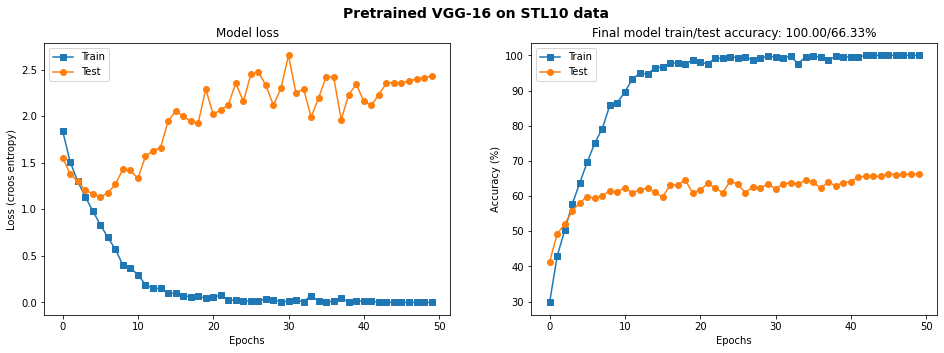

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (croos entropy)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

# testing with non-permuted images

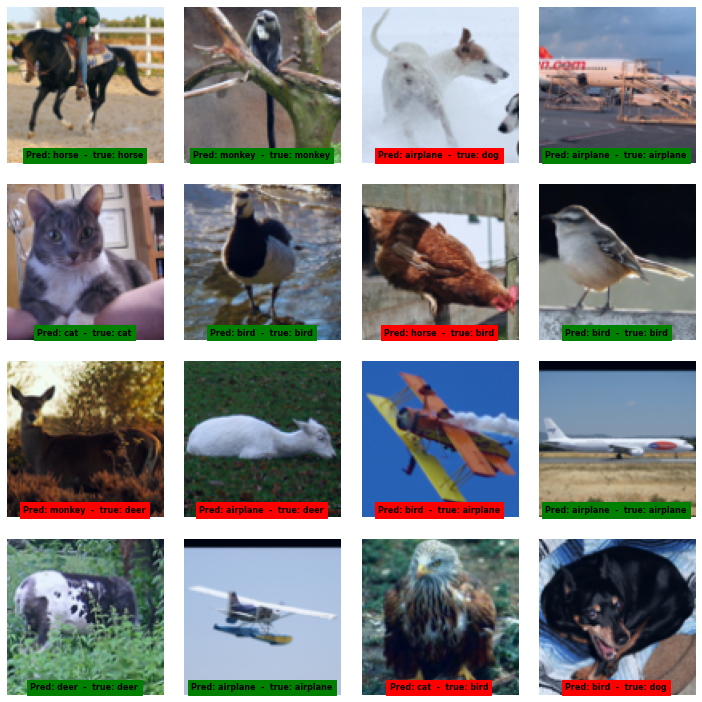

In [ ]:
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

net.eval()

predictions = torch.argmax( net(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
net.eval()
batchAcc  = []
batchLoss = []

for X,y in test_loader:

  X = X.to(device)
  y = y.to(device)

  with torch.no_grad():
    yHat = net(X)
    loss = lossfun(yHat,y)
  
  batchLoss.append(loss.item())
  batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )


testLoss = np.mean(batchLoss)
testAcc  = 100*np.mean(batchAcc)

In [ ]:
testLoss,testAcc

(2.430335395038128, 66.3330078125)

# testing with permuted images

In [ ]:
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # further normalization
                        T.Resize((98,98)),
                        Permutar(7)
                       ])


testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)
test_loader  = DataLoader(testset, batch_size=32)

Files already downloaded and verified


In [ ]:

#### test performance
net.eval()
batchAcc  = []
batchLoss = []

for X,y in test_loader:

  X = X.to(device)
  y = y.to(device)

  with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

  batchLoss.append(loss.item())
  batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )


testLoss = np.mean(batchLoss)
testAcc  = 100*np.mean(batchAcc)

In [ ]:
testLoss,testAcc

(6.572097882628441, 13.37890625)

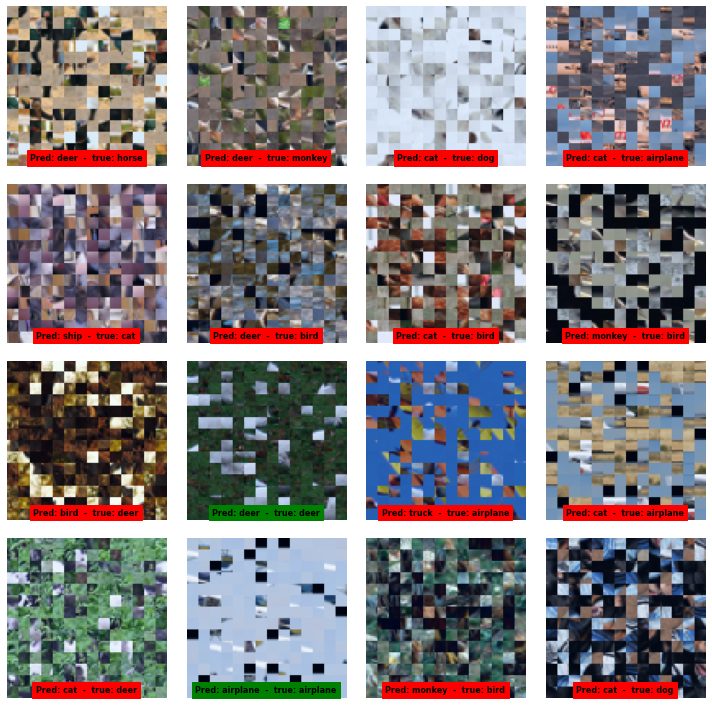

In [ ]:
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

net.eval()

predictions = torch.argmax( net(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

# devolver features

In [ ]:
kernel_aux = torch.ones(7,7).cuda()
#### test performance
net.eval()
batchAcc  = []
batchLoss = []

for X,y in test_loader:

  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
      results = net.conv1(X)
      results = torch.kron(results,kernel_aux)
      results = results.cpu().numpy().transpose((0,2,3,1))
      results = img.reordenar(results,True).transpose((0,3,1,2))
      yHat = net.vgg(torch.from_numpy(results).cuda())

      loss = lossfun(yHat,y)

  batchLoss.append(loss.item())
  batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )

  break


testLoss = np.mean(batchLoss)
testAcc  = 100*np.mean(batchAcc)

In [ ]:
testLoss,testAcc

(3.392324209213257, 9.375)

# aasd

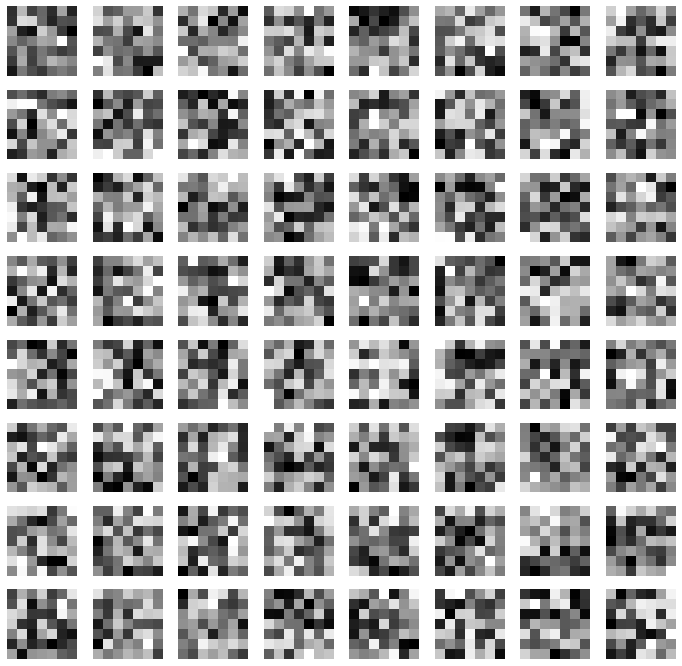

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(12, 12))
for i, filter in enumerate(list(net.children())[0].weight):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
img = X

In [ ]:
# pass the image through all the layers
results = list(net.children())[0](img.cuda())
results.cpu().shape

torch.Size([64, 14, 14])

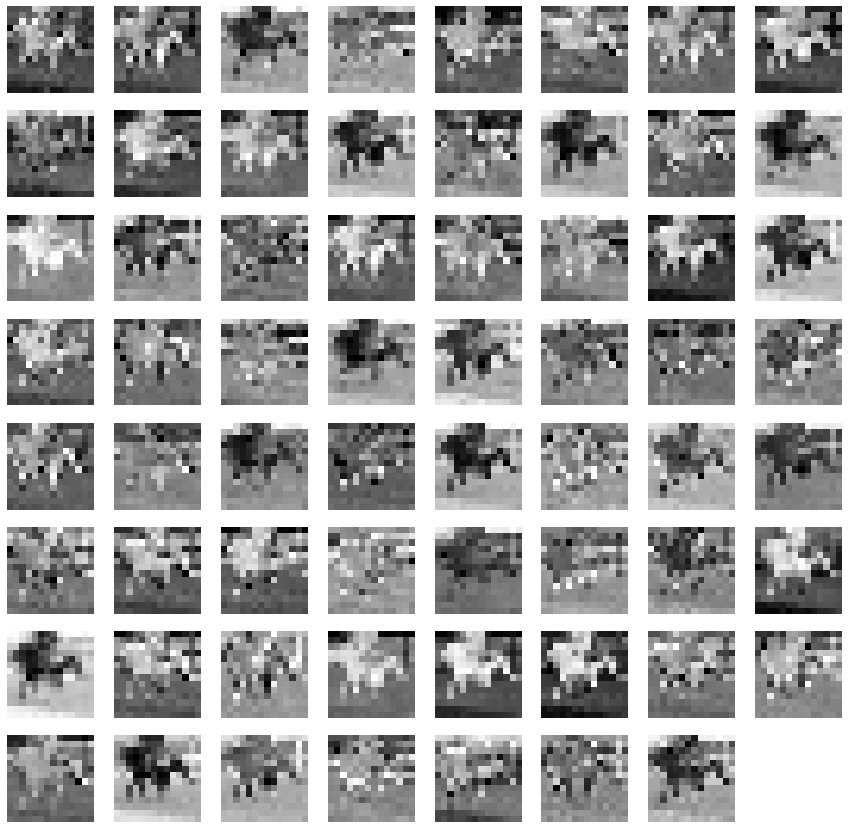

In [ ]:
plt.figure(figsize=(15, 15))
layer_viz = results.data
for i, filter in enumerate(layer_viz):
    if i == 63: # we will visualize only 8x8 blocks from each layer
        break
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter.cpu(), cmap='gray')
    plt.axis("off")

(<matplotlib.image.AxesImage at 0x7f261602f4c0>,
 <matplotlib.colorbar.Colorbar at 0x7f2616039c10>)

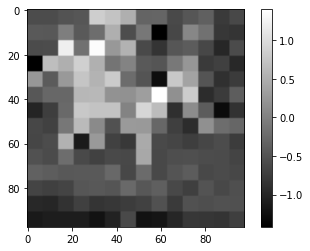

In [ ]:
kernel_aux = torch.ones(7,7)
real_img = torch.kron(layer_viz[0].cpu(),kernel_aux)
plt.imshow(real_img,cmap='gray'),plt.colorbar()

## mismo modelo, imagen permutada

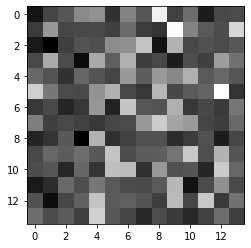

In [ ]:
results = list(net.children())[0](torch.from_numpy(permuted_image.transpose((2,0,1))).cuda())

plt.imshow(results[0].detach().cpu(), cmap='gray')

(<matplotlib.image.AxesImage at 0x7f26161ac8e0>,
 <matplotlib.colorbar.Colorbar at 0x7f261627d1f0>)

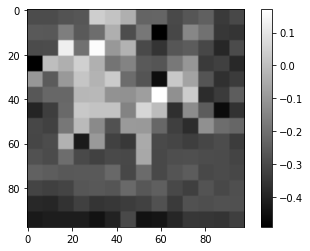

In [ ]:
aux_img = torch.kron(results[0].detach().cpu(),kernel_aux)
aux_img = np.stack((aux_img.numpy(),)*3, axis=-1)
aux_img = img.reordenar(aux_img)
plt.imshow(aux_img[:,:,0],cmap='gray'),plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f25fff79d60>,
 <matplotlib.colorbar.Colorbar at 0x7f25ffed59a0>)

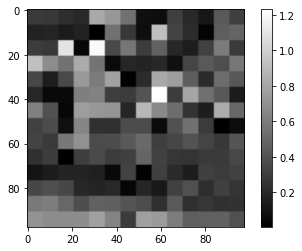

In [ ]:
plt.imshow(np.abs(real_img - aux_img[:,:,0]),cmap='gray'),plt.colorbar()

In [ ]:
torch.save(vggnet.state_dict(), './net')

Mounted at /content/drive


In [ ]:
torch.save(vggnet.state_dict(), './drive/MyDrive/net_')